<a href="https://colab.research.google.com/github/tkavya-05/SIL/blob/main/SIL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from torch.utils.data import DataLoader, Dataset
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
class CrowSPairsDataset(Dataset):
    def __init__(self, data_path):
        self.data = pd.read_csv(data_path)
        self.tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
        self.max_length = 128  # Maximum sequence length for tokenization

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # Extract sentences from the dataset
        sentence_1 = self.data.iloc[idx]['sent_more']
        sentence_2 = self.data.iloc[idx]['sent_less']

        # Tokenize the sentences
        inputs_1 = self.tokenizer(sentence_1, return_tensors="pt", padding="max_length", truncation=True, max_length=self.max_length)
        inputs_2 = self.tokenizer(sentence_2, return_tensors="pt", padding="max_length", truncation=True, max_length=self.max_length)

        # Return tokenized inputs
        return {
            "inputs_1": {k: v.squeeze(0) for k, v in inputs_1.items()},
            "inputs_2": {k: v.squeeze(0) for k, v in inputs_2.items()}
        }

# Define Bias Classifier
class BiasClassifier(nn.Module):
    def __init__(self, model_name="bert-base-uncased"):
        super(BiasClassifier, self).__init__()
        self.bert = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)

    def forward(self, input_ids, attention_mask):
        output = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        return output.logits

# Define Self-Imitation Learning Class
class SelfImitationLearning:
    def __init__(self, model, optimizer, device):
        self.model = model.to(device)
        self.optimizer = optimizer
        self.device = device
        self.replay_buffer = []

    def calculate_reward(self, output_1, output_2):
        pred_1 = torch.argmax(output_1, dim=-1)
        pred_2 = torch.argmax(output_2, dim=-1)
        return (pred_1 == pred_2).float().mean()

    def update_replay_buffer(self, experience, reward, threshold=0.9):
        if reward >= threshold:
            self.replay_buffer.append((experience, reward))

    def train_step(self, inputs_1, inputs_2):
        self.model.train()

        output_1 = self.model(input_ids=inputs_1['input_ids'].to(self.device),
                              attention_mask=inputs_1['attention_mask'].to(self.device))

        output_2 = self.model(input_ids=inputs_2['input_ids'].to(self.device),
                              attention_mask=inputs_2['attention_mask'].to(self.device))

        reward = self.calculate_reward(output_1, output_2)

        criterion = nn.CrossEntropyLoss()
        loss_1 = criterion(output_1, torch.argmax(output_1, dim=-1))
        loss_2 = criterion(output_2, torch.argmax(output_2, dim=-1))
        loss = (loss_1 + loss_2) / 2

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        self.update_replay_buffer((inputs_1, inputs_2), reward.item())

        return loss.item(), reward.item()

    def self_imitation_learning(self, num_iterations=10):
        for _ in range(num_iterations):
            for experience, _ in self.replay_buffer:
                inputs_1, inputs_2 = experience

                output_1 = self.model(input_ids=inputs_1['input_ids'].to(self.device),
                                      attention_mask=inputs_1['attention_mask'].to(self.device))

                output_2 = self.model(input_ids=inputs_2['input_ids'].to(self.device),
                                      attention_mask=inputs_2['attention_mask'].to(self.device))

                criterion = nn.CrossEntropyLoss()
                loss_1 = criterion(output_1, torch.argmax(output_1, dim=-1))
                loss_2 = criterion(output_2, torch.argmax(output_2, dim=-1))
                loss = (loss_1 + loss_2) / 2

                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()

In [4]:
def train_model(data_path, epochs=10):
    dataset = CrowSPairsDataset(data_path)
    data_loader = DataLoader(dataset, batch_size=8, shuffle=True)
    model_name = "bert-base-uncased"
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = BiasClassifier(model_name)
    optimizer = optim.Adam(model.parameters(), lr=1e-5)
    sil_trainer = SelfImitationLearning(model, optimizer, device)

    losses, rewards = [], []

    for epoch in range(epochs):
        total_loss, total_reward = 0, 0
        for batch in data_loader:
            inputs_1 = batch["inputs_1"]
            inputs_2 = batch["inputs_2"]
            loss, reward = sil_trainer.train_step(inputs_1, inputs_2)
            total_loss += loss
            total_reward += reward

        average_loss = total_loss / len(data_loader)
        average_reward = total_reward / len(data_loader)

        losses.append(average_loss)
        rewards.append(average_reward)

        print(f"Epoch {epoch + 1} - Loss: {average_loss}, Reward: {average_reward}")
        sil_trainer.self_imitation_learning(num_iterations=5)

    return losses, rewards

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1 - Loss: 0.04027768210187633, Reward: 1.0
Epoch 2 - Loss: 0.00010964638127319554, Reward: 1.0
Epoch 3 - Loss: 1.913995448188553e-05, Reward: 1.0
Epoch 4 - Loss: 4.095090492916473e-06, Reward: 1.0
Epoch 5 - Loss: 7.402878384796384e-07, Reward: 1.0


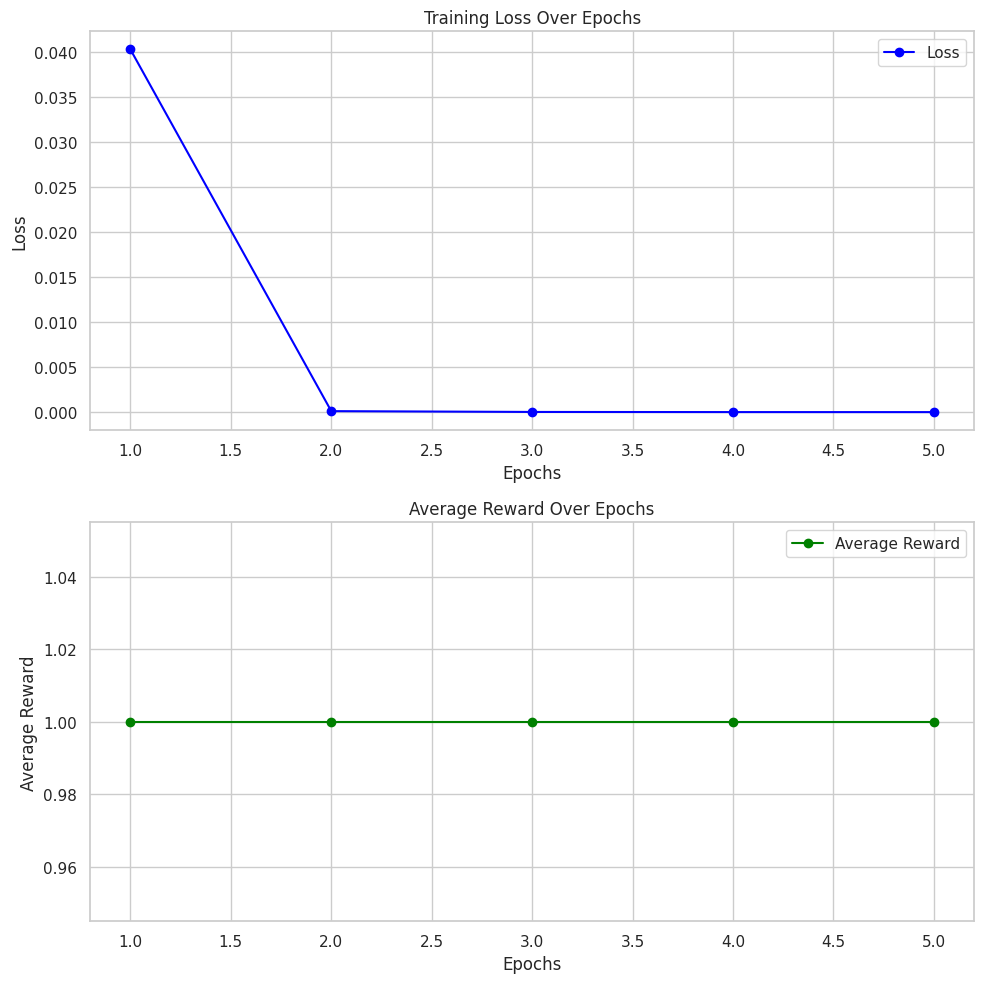

In [9]:
def plot_metrics(losses, rewards, epochs):
    sns.set(style="whitegrid")

    fig, axs = plt.subplots(2, 1, figsize=(10, 10))

    axs[0].plot(range(1, epochs + 1), losses, marker='o', color='blue', label='Loss')
    axs[0].set_title('Training Loss Over Epochs')
    axs[0].set_xlabel('Epochs')
    axs[0].set_ylabel('Loss')
    axs[0].legend()
    axs[0].grid(True)

    axs[1].plot(range(1, epochs + 1), rewards, marker='o', color='green', label='Average Reward')
    axs[1].set_title('Average Reward Over Epochs')
    axs[1].set_xlabel('Epochs')
    axs[1].set_ylabel('Average Reward')
    axs[1].legend()
    axs[1].grid(True)

    plt.tight_layout()
    plt.show()

# File Path
data_path = "./drive/My Drive/counterfactual data agumentation/crows_pairs_anonymized.csv"
epochs = 5
losses, rewards = train_model(data_path, epochs=epochs)
plot_metrics(losses, rewards, epochs)

In [11]:
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# Function to take input text and give output
def predict_bias(sentence_1, sentence_2, model, tokenizer, device):
    # Tokenize the input sentences
    inputs_1 = tokenizer(sentence_1, return_tensors="pt", padding="max_length", truncation=True, max_length=128)
    inputs_2 = tokenizer(sentence_2, return_tensors="pt", padding="max_length", truncation=True, max_length=128)

    # Move tensors to device (GPU/CPU)
    inputs_1 = {k: v.to(device) for k, v in inputs_1.items()}
    inputs_2 = {k: v.to(device) for k, v in inputs_2.items()}

    # Get predictions from the model
    with torch.no_grad():
        output_1 = model(**inputs_1)  # Unpack inputs for the model
        output_2 = model(**inputs_2)  # Unpack inputs for the model

    # The output is just the logits, so access it directly
    logits_1 = output_1[0]  # In case the model outputs a tuple, we need the first element (logits)
    logits_2 = output_2[0]  # Same here for the second output

    # Apply softmax to get probabilities (optional, if you want to interpret the output as probabilities)
    probabilities_1 = torch.softmax(logits_1, dim=-1)
    probabilities_2 = torch.softmax(logits_2, dim=-1)

    # Return the model outputs
    return probabilities_1, probabilities_2

# Main function to execute
def main():
    # Example custom text pairs (you can replace these with your inputs)
    sentence_1 = input("Enter the first sentence: ")
    sentence_2 = input("Enter the second sentence: ")

    # Load model and tokenizer
    model_name = "bert-base-uncased"
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)  # Load the model correctly

    # Load model to appropriate device (GPU if available, else CPU)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)

    # Get the prediction
    probabilities_1, probabilities_2 = predict_bias(sentence_1, sentence_2, model, tokenizer, device)

    # Print the results
    print(f"Prediction for Sentence 1: {probabilities_1}")
    print(f"Prediction for Sentence 2: {probabilities_2}")

if __name__ == "__main__":
    main()


Enter the first sentence: The woman is a nurse.
Enter the second sentence: The man is a doctor.


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Prediction for Sentence 1: tensor([[0.3595, 0.6405]], device='cuda:0')
Prediction for Sentence 2: tensor([[0.3773, 0.6227]], device='cuda:0')
